In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [52]:
# Data read
df = pd.read_csv('SQLiV3.csv')
df.head()

,Sentence,Label,Unnamed: 2,Unnamed: 3
0,""" or pg_sleep ( __TIME__ ) --",1,NaN,NaN
1,create user name identified by pass123 tempora...,NaN,1,NaN
2,AND 1 = utl_inaddr.get_host_address ( ...,1,NaN,NaN
3,select * from users where id = '1' or @ @1 ...,1,NaN,NaN
4,"select * from users where id = 1 or 1#"" ( ...",1,NaN,NaN


In [53]:
# Data Cleaning

# Remove unwanted columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3'], inplace=True)

# See the variety of unique values in the 'Label' column before cleaning
print("--- Unique values in 'Label' column BEFORE cleaning ---")
print(df['Label'].value_counts(dropna=False).head(10))

# Convert the 'Label' column to a numeric type.
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')

# All invalid text and previous NaNs are marked as NaN.
print(f"\nShape of DataFrame before dropping invalid rows: {df.shape}")
df.dropna(subset=['Label'], inplace=True)
print(f"Shape of DataFrame after dropping invalid rows: {df.shape}")


# Coverting float to int (if present)
df['Label'] = df['Label'].astype(int)

# Final verification
print("\n--- Unique values in 'Label' column AFTER cleaning ---")
print(df['Label'].unique())
print("\nData cleaning complete! The 'Label' column is now clean and ready. ✅")

--- Unique values in 'Label' column BEFORE cleaning ---
Label
0                                                                       19268
1                                                                       11341
NaN                                                                       255
 --                                                                        11
waitfor delay '0:0:__TIME__'--                                              5
 DROP TABLE Suppliers                                                       2
 if not  (  select system_user  )   <> 'sa' waitfor delay '0:0:2' --        1
 desc users                                                                 1
 execute immediate 'sel' || 'ect us' || 'er'                                1
 exec xp_regread                                                            1
Name: count, dtype: int64

Shape of DataFrame before dropping invalid rows: (30919, 2)
Shape of DataFrame after dropping invalid rows: (30609, 2)

--- Unique 

/tmp/ipython-input-3203546825.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label', data=df, palette='viridis', order=df['Label'].value_counts().index)
/tmp/ipython-input-3203546825.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Safe (0)', 'Malicious (1)'])


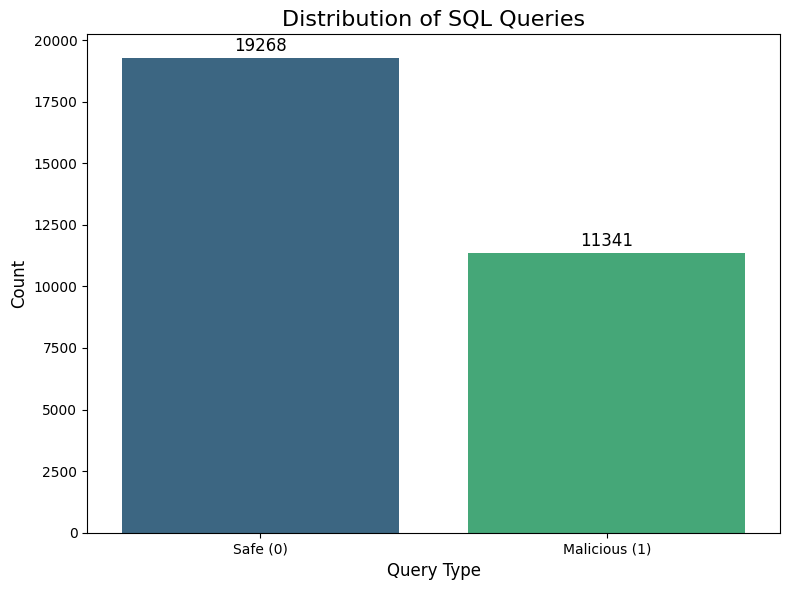

In [54]:
# Plotting figures

# Ensure the 'Label' column is of integer type for clean plotting
df['Label'] = df['Label'].astype(int)

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Label', data=df, palette='viridis', order=df['Label'].value_counts().index)

# Set the title and labels with better font sizes
ax.set_title('Distribution of SQL Queries', fontsize=16)
ax.set_xlabel('Query Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Set custom labels for the x-axis ticks
ax.set_xticklabels(['Safe (0)', 'Malicious (1)'])

# Add the count annotations on top of the bars for clarity
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12,
                color='black')

plt.tight_layout()
plt.show()

In [55]:
# Preprocessing

def preprocess_query(query):
    # Convert to lowercase
    query = str(query).lower()
    return query

# Apply the function to the 'Sentence' column
df['Cleaned_Sentence'] = df['Sentence'].apply(preprocess_query)


vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5))
X = vectorizer.fit_transform(df['Cleaned_Sentence'])
y = df['Label']

print(f"\nFeature Matrix Shape:")
print(f"The feature matrix has {X.shape[0]} rows (queries) and {X.shape[1]} features (character n-grams).")


Feature Matrix Shape:
The feature matrix has 30609 rows (queries) and 226327 features (character n-grams).


In [56]:
# Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Split:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Initialize and train the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

Data Split:
Training set size: 24487 samples
Testing set size: 6122 samples


LogisticRegression(random_state=42, solver='liblinear')

--- Model Accuracy ---
Accuracy: 0.9786 (97.86%)

--- Classification Report ---
               precision    recall  f1-score   support

     Safe (0)       0.97      1.00      0.98      3854
Malicious (1)       1.00      0.94      0.97      2268

     accuracy                           0.98      6122
    macro avg       0.98      0.97      0.98      6122
 weighted avg       0.98      0.98      0.98      6122



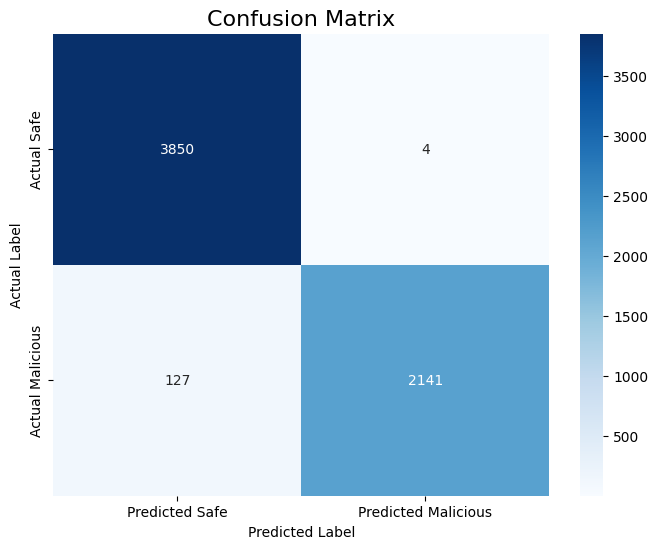

In [57]:
# Performance Metrics

y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"--- Model Accuracy ---")
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Classification Report
# This gives us precision, recall, and f1-score.
# For security, 'recall' for the malicious class (1) is very important!
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Safe (0)', 'Malicious (1)']))

# Confusion Matrix
# This shows us exactly where the model made correct and incorrect predictions.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Malicious'],
            yticklabels=['Actual Safe', 'Actual Malicious'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()